# Patch identification algorithm from Lab 9

Identifying contiguous patches is not as simple as it seems.
While the eye is very good at spotting contiguous groups of similarly valued data,
it is a bit challenging to write an algorithm that groups contiguous "patches".

This algorithm has 2 phases:
 1. give each non-empty cell a unique identifier;
 2. consolidate neighbouring non-empty cells until no further consolidation is possible.


In [2]:
%matplotlib inline

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
some previously defined code to plot and animate arrays...

In [3]:
# Qualitative colour map with value 0 set to white
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

DEFAULT_IMSHOW_OPTIONS = dict(
    cmap=tab20_mod,
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [4]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

## Patchify
The main algorithm is coded here as a class with step and draw methods so the algorithm can be animated.

In [13]:
neighbourhood = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0],
])
centre = tuple(d // 2 for d in neighbourhood.shape)


def max_neighbour(a):
    """ Return the largest non-zero neighbourhood value or 0 if centre cell is a zero """
    assert a.shape == neighbourhood.shape
    p = a * neighbourhood
    return 0 if a[centre]==0 else np.max(p[p > 0])

assert max_neighbour(np.array([[1, 2, 3], [0, 1, 0], [1, 2, 3] ])) == 2
assert max_neighbour(np.array([[1, 2, 3], [0, 0, 0], [1, 2, 3] ])) == 0
assert max_neighbour(np.array([[1, 0, 1], [0, 2, 0], [1, 0, 1] ])) == 2

def consolidate(array):
    """ return copy of array with adjacent cells consolidated into a patch with the lowest value among occupied neighbours """
    rows, cols = array.shape
    array = np.pad(array, 1, mode='wrap')  # wraps edges
    k = neighbourhood.shape[0]
    return np.array([
        [max_neighbour(array[row:row + k, col:col + k]) for col in range(cols)]
        for row in range(rows)
    ], dtype=np.uint)

def patchify(array, patch_category):
    """ Return an array with each contiguous patch identified by a unique integer
    array:  array of int categorical values.
    category: the category value to identify patches for.

    return: array of same shape with a unique value identifying cells in each patch and zeros elsewhere.
    """
    patches = np.zeros(array.shape, dtype=np.uint)
    # assign each cell that falls in a patch a unique number, 1 .. N
    patches[array == patch_category] = range(100, len(array[array == patch_category]) + 100)

    patches_growing = True
    while patches_growing:
        prev_patches = patches
        patches = consolidate(prev_patches)
        patches_growing = np.any(patches != prev_patches)  # patches are growing until consolidate algorithm stabilizes.

    return patches

Patch id's: [100 111 123 124]


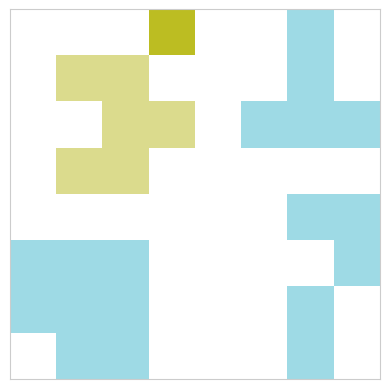

In [14]:
# test patchify
a = np.array([
    [0, 0, 0, 1, 5, 0, 1, 0],
    [0, 1, 1, 0, 5, 0, 1, 0],
    [0, 0, 1, 1, 5, 1, 1, 1],
    [0, 1, 1, 0, 5, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 1, 1],
    [1, 1, 1, 0, 5, 0, 0, 1],
    [1, 1, 1, 0, 5, 0, 1, 0],
    [0, 1, 1, 0, 5, 0, 1, 0],
], dtype=np.uint)
pch = patchify(a, 1)
plot_2D_array(pch)
print("Patch id's:", np.unique(pch[pch>0]))

#### Test
As a rough test, create a random array of categorical values, and patchify on each catgegory...

Patch sets for 2-valued random array


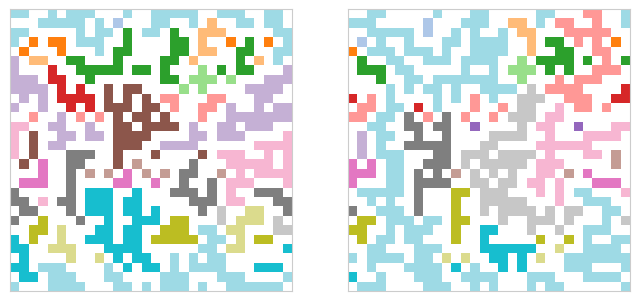

In [10]:
# test patchify
cats = 2
cat_vals = list(range(1, cats+1))
a = np.random.choice(cat_vals, (30,30))
patch_sets = [patchify(a, i) for i in cat_vals]
print(f'Patch sets for {cats}-valued random array')
_, ax = plt.subplots(1, cats, figsize=(cats*4, 4))
for i in range(cats):
    plot_2D_array(patch_sets[i], axes=ax[i])

### Algorithm animation
An animation makes it clear how the algoirthm works.

In [8]:
class Patches:
    """ Animate the patchify algorithm to illustrate how it works.  For practical applications, use patchify function."""
    def __init__(self, array, patch_category):
        self.patches = np.zeros(array.shape, dtype=np.uint)
        # assign each cell that falls in a patch a unique number, 1 .. N
        self.patches[array == patch_category] = np.array(range(100, len(array[array == patch_category]) + 100))

        self.patches_growing = True

    def step(self):
        if self.patches_growing:
            prev_patches = self.patches
            self.patches = consolidate(prev_patches)
            self.patches_growing = np.any(self.patches != prev_patches)  # patches are growing until consolidate algorithm stabilizes.

    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        plot_2D_array(self.patches, axes=axes, title=f"Patchifying {self.patches_growing}",)

In [19]:
pch = Patches(np.random.choice((0,1), (30,30)), 1)
anim = Animation2D(pch, frames=40)
anim.show()